In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# parametri fisici oscillatore
m = 1.
omega = 1.
#k_B = 1.38065156*10**(-23)
k_B = 1.
T = 10
r = 0.01 #0.05
beta = 1/(k_B*T)

In [3]:
# campo vettoriale della dinamica

#def forza(q):
#    return -m*(omega**2)*q

def forza(q):
    return -m*(omega**2)*q - r*q**3

In [4]:
# definisco lo step temporale
h = 0.01

# definisco le costanti per l'algoritmo di yoshida
denominatore = 2-2**(1/3)

w_0 = -(2**(1/3))/denominatore
w_1 = 1/denominatore

c_1 = w_1/2
c_2 = (w_0 + w_1)/2
c_3 = c_2
c_4 = c_1

d_1 = w_1
d_2 = w_0
d_3 = w_1

In [5]:
# yoshida-4
def yoshida_4(q, p):

    q_temp_1 = q + c_1*p/m*h
    p_temp_1 = p + d_1*forza(q_temp_1)*h

    q_temp_2 = q_temp_1 + c_2*p_temp_1/m*h
    p_temp_2 = p_temp_1 + d_2*forza(q_temp_2)*h

    q_temp_3 = q_temp_2 + c_3*p_temp_2/m*h
    p_temp_3 = p_temp_2 + d_3*forza(q_temp_3)/m*h

    q_evoluto = q_temp_3 + c_4*p_temp_3/m*h
    p_evoluto = p_temp_3

    return q_evoluto, p_evoluto

In [6]:
# Definizione della distribuzione di Gibbs
def gibbs_distribution(q, p):
    return np.exp(-beta*((p**2)/(2*m) + (m*omega**2)*(q**2)/2))

def gibbs_distribution_nonlinear(q, p):
    return np.exp(-beta*((p**2)/(2*m) + (m*omega**2)*(q**2)/2 + r*(q**4)/4))

In [7]:
# Definizione della proposta di transizione (scelta semplice per dimostrazione)
def proposal(x, y):
    x_new = x + np.random.normal()
    y_new = y + np.random.normal()
    return x_new, y_new

In [8]:
# Parametri dell'algoritmo di campionamento
num_samples = 50
burn_in = 50

In [9]:
# Inizializzazione campionamento
current_q, current_p = 0.0, 0.0
samples = []

In [10]:
# Ciclo di campionamento delle q e delle p
for _ in range(num_samples + burn_in):
    proposed_q, proposed_p = proposal(current_q, current_p)
    
    acceptance_ratio = min(1, gibbs_distribution_nonlinear(proposed_q, proposed_p) / gibbs_distribution_nonlinear(current_q, current_p))
    
    if np.random.uniform() < acceptance_ratio:
        current_q, current_p = proposed_q, proposed_p
    
    if _ >= burn_in:
        samples.append((current_q, current_p))

In [11]:
# Estrazione dei campioni di x e y
sampled_q = [sample[0] for sample in samples]
sampled_p = [sample[1] for sample in samples]

sampled_q = np.array(sampled_q) 
sampled_p = np.array(sampled_p) 

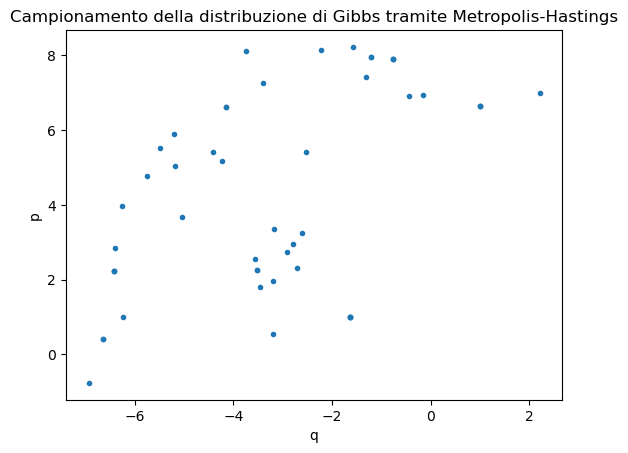

In [12]:
# Visualizzazione dei risultati
plt.scatter(sampled_q, sampled_p, marker='.')
plt.xlabel('q')
plt.ylabel('p')
plt.title('Campionamento della distribuzione di Gibbs tramite Metropolis-Hastings')
plt.show()

In [13]:
len(sampled_p) == len(sampled_q)

True

In [14]:
np.mean(sampled_p*sampled_p/m)

26.20122512350562

In [15]:
np.mean((m*omega*omega)*sampled_q*sampled_q)

15.35856641623266

In [16]:
np.mean((m*omega*omega)*sampled_q*sampled_q + r*sampled_q*sampled_q*sampled_q*sampled_q)

19.96351039922568

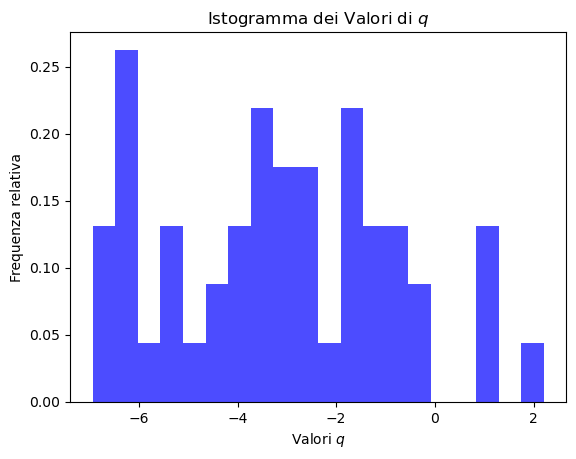

In [17]:
# Crea l'istogramma
plt.hist(sampled_q, bins=20, density=True, alpha=0.7, color='blue')  # `bins` definisce il numero di bin nell'istogramma

# Aggiungi etichette e titolo
plt.xlabel('Valori $q$')
plt.ylabel('Frequenza relativa')
plt.title('Istogramma dei Valori di $q$')

# Mostra il plot
plt.show()

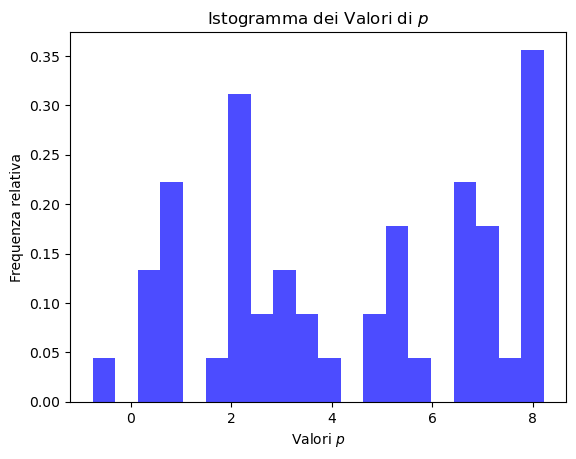

In [18]:
# Crea l'istogramma
plt.hist(sampled_p, bins=20, density=True, alpha=0.7, color='blue')  # `bins` definisce il numero di bin nell'istogramma

# Aggiungi etichette e titolo
plt.xlabel('Valori $p$')
plt.ylabel('Frequenza relativa')
plt.title('Istogramma dei Valori di $p$')

# Mostra il plot
plt.show()

In [19]:
kinetic = (sampled_p*sampled_p)/(2*m)
# potential = (m*omega*omega/2)*(sampled_q*sampled_q)
potential = (m*omega*omega/2)*(sampled_q*sampled_q) + (r/4)*(sampled_q*sampled_q)*(sampled_q*sampled_q)
energy = kinetic + potential

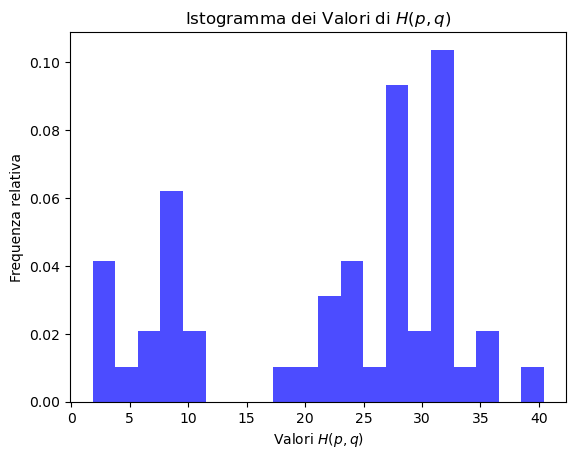

In [20]:
# Crea l'istogramma
plt.hist(energy, bins=20, density=True, alpha=0.7, color='blue')  # `bins` definisce il numero di bin nell'istogramma

# Aggiungi etichette e titolo
plt.xlabel('Valori $H(p,q)$')
plt.ylabel('Frequenza relativa')
plt.title('Istogramma dei Valori di $H(p,q)$')

# Mostra il plot
plt.show()

In [21]:
from multiprocessing import Pool

# definisco il numero di step
N = 10
# definisco la taglia dell'ensemble
ensemble_size = len(sampled_q)

In [22]:
# Funzione per l'avanzamento temporale di una singola realizzazione
def evolve_realization(realization):
    q_0 = sampled_q[realization]
    p_0 = sampled_p[realization]

    q_evoluzione = np.empty(N)
    p_evoluzione = np.empty(N)
    
    q_evoluzione[0] = q_0
    p_evoluzione[0] = p_0

    for i in range(N-1):
        q_evoluzione[i+1], p_evoluzione[i+1] = yoshida_4(q_evoluzione[i], p_evoluzione[i])

    return q_evoluzione, p_evoluzione

In [ ]:
# Numero di processi da utilizzare (può essere ottimizzato in base all'hardware)
num_processes = 16

if __name__ == "__main__":
    with Pool(num_processes) as pool:
        results = pool.map(evolve_realization, range(ensemble_size))

    # Calcola la somma delle evoluzioni di tutte le realizzazioni
    q_ensemble = np.sum([result[0] for result in results], axis=0)
    p_ensemble = np.sum([result[1] for result in results], axis=0)

In [ ]:
plt.plot(q_ensemble, p_ensemble)

In [ ]:
plt.plot(p_ensemble*p_ensemble + q_ensemble*q_ensemble +  q_ensemble*q_ensemble*q_ensemble*q_ensemble)
plt.ylim([0, 0.01])